# Table Extraction Case Study
### AAIC Self Case Study II
### Author: Soumya De

<hr>

## 4. Experimenting with different pretrained models

In this section we will try to experiment with different CNN architecture to compare performance. In the previous section we have used VGG19 from tf.keras.applications as our base encoder, now we will replace the the VGG19 encoder with pretrained tensorflow models :


### Data pipeline

In [1]:
# importing dependencies
import os
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
from PIL import Image, ImageDraw
import pytesseract
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, Dropout, Layer, UpSampling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.applications import VGG19, DenseNet121, MobileNetV3Large, EfficientNetB0, Xception, ResNet50

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# defining required functions
# defining function for loading the images into memory
# it will also perform resizing and normalizing at the time of loading 
def _parse_function(image, mask, colmask):
    dim = (512,512)
    image_decoded = tf.io.decode_png(tf.io.read_file(image), channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, dim)
    image = tf.cast(image, tf.float32) / 255.0
    
    mask_decoded = tf.io.decode_png(tf.io.read_file(mask), channels=1)
    mask = tf.cast(mask_decoded, tf.float32)
    mask = tf.image.resize(mask, dim)
    mask = tf.cast(mask, tf.float32) / 255.0

    colmask_decoded = tf.io.decode_png(tf.io.read_file(colmask), channels=1)
    colmask = tf.cast(colmask_decoded, tf.float32)
    colmask = tf.image.resize(colmask, dim)
    colmask = tf.cast(colmask, tf.float32) / 255.0
    
    mask_dict = {'table': mask, 'column': colmask}

    return image, mask_dict

# function to display a list of images
def visualize(image_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'Table Mask', 'Column Mask']
  for i in range(len(image_list)):
    plt.subplot(1, len(image_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
    plt.axis('off')
  plt.show()

# visualizing initial predictions (without training)
def render(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

In [3]:
# defining data directory and reading data
tr_data_dir = os.path.join('data', 'marmot_masked')
train_df = pd.read_csv(os.path.join(tr_data_dir, 'data.csv'))

In [4]:
#defining tensorflow dataset
tf.keras.backend.clear_session()
dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['tablemask_path'].values, train_df['columnmask_path'].values))

In [5]:
# defining training parameters
DATA_SIZE = len(dataset)
VAL_SIZE = 0.1
VAL_LENGTH = int(VAL_SIZE*DATA_SIZE)
TRAIN_LENGTH = int((1-VAL_SIZE) * DATA_SIZE)
BATCH_SIZE = 1
BUFFER_SIZE = TRAIN_LENGTH
VAL_BUFFER_SIZE = VAL_LENGTH
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [6]:
# defining data loading mechanisms
train = dataset.take(TRAIN_LENGTH)
val = dataset.skip(TRAIN_LENGTH)
train = train.map(_parse_function)
val = val.map(_parse_function)

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val.shuffle(VAL_BUFFER_SIZE).batch(BATCH_SIZE)

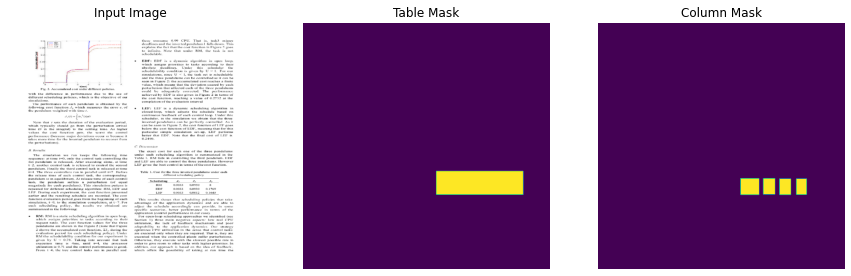

In [7]:
for image, mask  in train.take(1):
  # print(mask.shape)
  visualize([image, mask['table'], mask['column']])

### Model definition

In [8]:
# defining custom layers and model building function
class TableConvLayer(Layer):
    def __init__(self, name='table'):
        super(TableConvLayer, self).__init__(name=name)
        self.conv7 = Conv2D(512, (1,1), activation='relu', name='conv7table')
        self.upsample_conv7 = UpSampling2D((2,2))
        self.concat_p4 = Concatenate()
        self.upsample_p4 = UpSampling2D((2,2))

        self.concat_p3 = Concatenate()
        self.upsample_p3 = UpSampling2D((2,2))

        self.upsample_p3_2 = UpSampling2D((2,2))
        self.convtranspose = Conv2DTranspose(3, (3,3), strides=2, padding='same')

    def call(self, inputs):
        X, pool3, pool4 = inputs
        X = self.conv7(X)
        X = self.upsample_conv7(X)
        
        X = self.concat_p4([X, pool4])
        X = self.upsample_p4(X)
        X = self.concat_p3([X, pool3])
        X = self.upsample_p3(X)
        X = self.upsample_p3_2(X)
        X = self.convtranspose(X)

        return X


class ColumnConvLayer(Layer):
    def __init__(self, name='column'):
        super(ColumnConvLayer, self).__init__(name=name)
        self.conv7 = Conv2D(512, (1,1), activation='relu', name='conv7column')
        self.dropout = Dropout(0.8)
        self.conv8 = Conv2D(512, (1,1), activation='relu', name='conv8column')
        self.upsample_conv8 = UpSampling2D((2,2))
        self.concat_p4 = Concatenate()
        self.upsample_p4 = UpSampling2D((2,2))

        self.concat_p3 = Concatenate()
        self.upsample_p3 = UpSampling2D((2,2))

        self.upsample_p3_2 = UpSampling2D((2,2))
        self.convtranspose = Conv2DTranspose(3, (3,3), strides=2, padding='same')


    def call(self, inputs):
        X, pool3, pool4 = inputs
        X = self.conv7(X)
        X = self.dropout(X)
        X = self.conv8(X)
        X = self.upsample_conv8(X)
        X = self.concat_p4([X, pool4])
        X = self.upsample_p4(X)
        X = self.concat_p3([X, pool3])
        X = self.upsample_p3(X)
        X = self.upsample_p3_2(X)
        X = self.convtranspose(X)

        return X


def build_tablenet(encoder='VGG19'):
    tf.keras.backend.clear_session()
    input_shape = (512,512,3)

    if encoder == 'VGG19':
        encoder_dict = {
            'base' : VGG19,
            'end_layers' :  ['block3_pool', 'block4_pool', 'block5_pool']
        }


    elif encoder == 'DenseNet121':
        encoder_dict = {
            'base' : DenseNet121,
            'end_layers' : ['pool3_pool','pool4_pool', 'relu']
        }

    elif encoder == 'EfficientNetB0':
        encoder_dict = {
            'base' : EfficientNetB0,
            'end_layers' : ['block5c_add','block6d_add', 'top_activation']
        }
    
    elif encoder == 'Xception':
        encoder_dict = {
            'base' : Xception,
            'end_layers' : ['block10_sepconv2_act','block12_sepconv2_act', 'block14_sepconv2_act']
        }

    elif encoder == 'ResNet50':
        encoder_dict = {
            'base' : ResNet50,
            'end_layers' : ['conv3_block4_3_conv','conv4_block6_3_conv', 'conv5_block3_out']
        }
    
    else:
        raise ValueError("Value of encoder must belong from [VGG19, DenseNet121, EfficientNetB0, Xception]")
    
    
    base = encoder_dict['base'](input_shape=input_shape, include_top=False, weights='imagenet')

    end_layers = [base.get_layer(i).output for i in encoder_dict['end_layers']]

    X = Conv2D(512, (1,1), activation='relu', name='block6_conv1')(end_layers[-1])
    X = Dropout(0.4)(X)
    X = Conv2D(512, (1,1), activation='relu', name='block6_conv2')(X)
    X = Dropout(0.4)(X)

    if encoder == 'VGG19':
        Y = end_layers[0]
        Z = end_layers[1]

    elif encoder == 'ResNet50':
        Y = Conv2D(256, (1,1))(end_layers[0])
        Z = Conv2D(512, (1,1))(end_layers[1])

    elif encoder == 'DenseNet121':
        Y = UpSampling2D((2,2))(end_layers[0])
        Z = UpSampling2D((2,2))(end_layers[1])  
    

    elif encoder == 'EfficientNetB0':
        Y = UpSampling2D((2,2))(end_layers[0])
        Y = Conv2D(256, (1,1))(Y)
        Z = UpSampling2D((2,2))(end_layers[1])
        Z = Conv2D(512, (1,1))(Z)

    
    elif encoder == 'Xception':
        Y = UpSampling2D((2,2))(end_layers[0])
        Y = Conv2D(256, (1,1))(Y)
        Z = Conv2D(512, (1,1))(end_layers[1])


    
    table_branch = TableConvLayer()([X, Y, Z])
    column_branch = ColumnConvLayer()([X, Y, Z])

    model = Model(inputs=base.input, outputs=[table_branch, column_branch], name='TableNet_' + encoder)
    return model

## Training tablenet by applying different encoder architechture

### a) DenseNet121

In [9]:
model = build_tablenet(encoder='DenseNet121')

In [10]:
model.summary()

Model: "TableNet_DenseNet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________

In [11]:
losses = {
    "table": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table": 1.0, "column": 1.0}
optim = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08)
sc_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='sc_accuracy')


model.compile(optimizer = optim,
              loss = losses,
              metrics = [sc_acc],
              loss_weights = lossWeights)

In [12]:
# defining model callbacks (checkpoint and tensorboard)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "tablenet_DenseNet_weights/cp_{epoch:04d}_{val_loss:.4f}.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

log_dir = "tablenet_DenseNet_logs"

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss', save_weights_only=True)

tb_callback = TensorBoard(log_dir)

callbacks = [cp_callback, tb_callback]

In [13]:
# model training
model.fit(
    train_dataset, epochs=100,
    steps_per_epoch= STEPS_PER_EPOCH,
    validation_data=val_dataset,
    validation_steps= VALIDATION_STEPS,
    callbacks=callbacks
)

Epoch 1/100
444/444 [==============================] - 170s 310ms/step - loss: 0.7217 - table_loss: 0.4013 - column_loss: 0.3204 - table_sc_accuracy: 0.8302 - column_sc_accuracy: 0.8710 - val_loss: 0.5264 - val_table_loss: 0.2600 - val_column_loss: 0.2664 - val_table_sc_accuracy: 0.9105 - val_column_sc_accuracy: 0.9054

Epoch 00001: val_loss improved from inf to 0.52640, saving model to tablenet_DenseNet_weights\cp_0001_0.5264.ckpt
Epoch 2/100
444/444 [==============================] - 128s 275ms/step - loss: 0.3414 - table_loss: 0.1799 - column_loss: 0.1616 - table_sc_accuracy: 0.9310 - column_sc_accuracy: 0.9237 - val_loss: 0.4599 - val_table_loss: 0.2214 - val_column_loss: 0.2386 - val_table_sc_accuracy: 0.9270 - val_column_sc_accuracy: 0.9150

Epoch 00002: val_loss improved from 0.52640 to 0.45994, saving model to tablenet_DenseNet_weights\cp_0002_0.4599.ckpt
Epoch 3/100
444/444 [==============================] - 134s 287ms/step - loss: 0.2842 - table_loss: 0.1364 - column_loss: 0.

### b) ResNet50

In [9]:
model = build_tablenet(encoder='ResNet50')

In [10]:
model.summary()

Model: "TableNet_ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________

In [11]:
losses = {
    "table": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table": 1.0, "column": 1.0}
optim = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08)
sc_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='sc_accuracy')


model.compile(optimizer = optim,
              loss = losses,
              metrics = [sc_acc],
              loss_weights = lossWeights)

In [12]:
# defining model callbacks (checkpoint and tensorboard)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "tablenet_ResNet_weights/cp_{epoch:04d}_{val_loss:.4f}.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

log_dir = "tablenet_ResNet_logs"

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss', save_weights_only=True)

tb_callback = TensorBoard(log_dir)

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10)

callbacks = [cp_callback, tb_callback, lr_callback]

In [13]:
# model training
model.fit(
    train_dataset, epochs=100,
    steps_per_epoch= STEPS_PER_EPOCH,
    validation_data=val_dataset,
    validation_steps= VALIDATION_STEPS,
    callbacks=callbacks
)

c:\Users\soumy\PROJECTS\Table_Extraction\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 1/100
444/444 [==============================] - 133s 263ms/step - loss: 0.6469 - table_loss: 0.3434 - column_loss: 0.3035 - table_sc_accuracy: 0.8532 - column_sc_accuracy: 0.8742 - val_loss: 1.0327 - val_table_loss: 0.5320 - val_column_loss: 0.5007 - val_table_sc_accuracy: 0.8175 - val_column_sc_accuracy: 0.8590

Epoch 00001: val_loss improved from inf to 1.03267, saving model to tablenet_ResNet_weights\cp_0001_1.0327.ckpt
Epoch 2/100
444/444 [==============================] - 119s 258ms/step - loss: 0.2703 - table_loss: 0.1378 - column_loss: 0.1324 - table_sc_accuracy: 0.9479 - column_sc_accuracy: 0.9377 - val_loss: 1.5515 - va

### c) EfficientNetB0

In [16]:
model = build_tablenet(encoder='EfficientNetB0')
model.summary()

Model: "TableNet_EfficientNetB0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________________________________________________________________

In [17]:
losses = {
    "table": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table": 1.0, "column": 1.0}
optim = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08)
sc_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='sc_accuracy')


model.compile(optimizer = optim,
              loss = losses,
              metrics = [sc_acc],
              loss_weights = lossWeights)

In [19]:
# defining model callbacks (checkpoint and tensorboard)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint_path = "tablenet_EfficientNet_weights/cp_{epoch:04d}_{val_loss:.4f}.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

log_dir = "tablenet_EfficientNet_logs"

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss', save_weights_only=True)

tb_callback = TensorBoard(log_dir)

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10)

es_callback = EarlyStopping(monitor='val_loss', patience=20) 

callbacks = [cp_callback, tb_callback, lr_callback, es_callback]

In [20]:
# model training
model.fit(
    train_dataset, epochs=100,
    steps_per_epoch= STEPS_PER_EPOCH,
    validation_data=val_dataset,
    validation_steps= VALIDATION_STEPS,
    callbacks=callbacks
)

c:\Users\soumy\PROJECTS\Table_Extraction\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 1/100
444/444 [==============================] - 217s 362ms/step - loss: 1.0529 - table_loss: 0.5462 - column_loss: 0.5067 - table_sc_accuracy: 0.8090 - column_sc_accuracy: 0.8286 - val_loss: 0.7044 - val_table_loss: 0.3828 - val_column_loss: 0.3216 - val_table_sc_accuracy: 0.8316 - val_column_sc_accuracy: 0.8644

Epoch 00001: val_loss improved from inf to 0.70439, saving model to tablenet_EfficientNet_weights\cp_0001_0.7044.ckpt
Epoch 2/100
444/444 [==============================] - 124s 267ms/step - loss: 0.3916 - table_loss: 0.2036 - column_loss: 0.1880 - table_sc_accuracy: 0.9219 - column_sc_accuracy: 0.9169 - val_loss: 0.988

### d) Xception

In [22]:
model = build_tablenet(encoder='Xception')
model.summary()

Model: "TableNet_Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________

In [23]:
losses = {
    "table": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table": 1.0, "column": 1.0}
optim = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08)
sc_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='sc_accuracy')


model.compile(optimizer = optim,
              loss = losses,
              metrics = [sc_acc],
              loss_weights = lossWeights)

In [24]:
# defining model callbacks (checkpoint and tensorboard)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint_path = "tablenet_Xception_weights/cp_{epoch:04d}_{val_loss:.4f}.ckpt" 
checkpoint_dir = os.path.dirname(checkpoint_path)

log_dir = "tablenet_Xception_logs"

if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

cp_callback = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss', save_weights_only=True)

tb_callback = TensorBoard(log_dir)

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10)

es_callback = EarlyStopping(monitor='val_loss', patience=20) 

callbacks = [cp_callback, tb_callback, lr_callback, es_callback]

In [25]:
# model training
model.fit(
    train_dataset, epochs=100,
    steps_per_epoch= STEPS_PER_EPOCH,
    validation_data=val_dataset,
    validation_steps= VALIDATION_STEPS,
    callbacks=callbacks
)

c:\Users\soumy\PROJECTS\Table_Extraction\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 1/100
444/444 [==============================] - 195s 401ms/step - loss: 0.6574 - table_loss: 0.3545 - column_loss: 0.3030 - table_sc_accuracy: 0.8524 - column_sc_accuracy: 0.8727 - val_loss: 0.3553 - val_table_loss: 0.1720 - val_column_loss: 0.1833 - val_table_sc_accuracy: 0.9267 - val_column_sc_accuracy: 0.9083

Epoch 00001: val_loss improved from inf to 0.35530, saving model to tablenet_Xception_weights\cp_0001_0.3553.ckpt
Epoch 2/100
444/444 [==============================] - 173s 378ms/step - loss: 0.2725 - table_loss: 0.1286 - column_loss: 0.1438 - table_sc_accuracy: 0.9513 - column_sc_accuracy: 0.9311 - val_loss: 0.3425 - 

## Saving results for the trained models
<hr>


In [20]:
# extract function
from time import strftime
import csv
def adjust(new_rows, maxi):
    """
    A function to set all with maxi number of columns
    for making csv compatible
    """
    rows = []
    for each_row in new_rows:
        if len(each_row) < maxi:
            for i in range(maxi - len(each_row)):
                each_row.append("-")
        rows.append(each_row)
    return rows

def text2csv(text):
    """
    This funtion transorms a text with newline and spaces to
    a csv that treats the spaces in the text as comma and newlines as carriage return
    """
    rows = text.split('\n')
    new_rows = []
    maxi = 0
    for each_row in rows:
        temp_row = each_row.split()
        if maxi < len(temp_row):
            maxi = len(temp_row)
        new_rows.append(temp_row)
    new_rows = adjust(new_rows, maxi)
    header = ['column_{}'.format(i) for i in range(maxi)]
    tstr = strftime("%Y%m%d-%H%M")
    temp_dir = os.path.join('output', 'temporary_files')
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    temp_file = os.path.join(temp_dir, 'temp_{}.csv'.format(tstr))

    with open(temp_file, 'w') as f:
        csvwriter = csv.writer(f)
        csvwriter.writerow(header)
        csvwriter.writerows(new_rows)
    return temp_file

def extract_table(image_fname, model, show_image='off'):
    """
    Given an image and an trained tablenet model, it extracts the detected table information
    in a csv file, with the help of the trained model, to 
    """
    image_orig = Image.open(image_fname)
    original_dim = image_orig.size
    image = image_orig.resize((512,512))
    np_image = np.asarray(image)/255.0
    tab_mask, _ = model.predict(np.expand_dims(np_image, axis=0))
    
    tab_mask = np.squeeze(render(tab_mask).numpy())

    tab_mask = Image.fromarray(np.uint8(tab_mask))
    tab_mask = tab_mask.resize(original_dim)

    tab_mask = np.array(tab_mask)

    kernel_erode = np.ones((20,20), np.uint8)
    kernel = np.ones((50,50), np.uint8)
    
    tab_mask =cv2.erode(tab_mask, kernel_erode, iterations=2)


    tab_mask = cv2.morphologyEx(tab_mask, cv2.MORPH_OPEN, kernel)
    tab_mask = cv2.morphologyEx(tab_mask, cv2.MORPH_CLOSE, kernel)

    image_orig = np.array(image_orig)
    masked = cv2.bitwise_and(image_orig, image_orig, mask=tab_mask)
    # Ref: https://stackoverflow.com/questions/62813546/how-do-i-crop-an-image-based-on-custom-mask-in-python
    # transparent cropp
    tmp = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(masked)
    rgba = [b,g,r, alpha]
    masked = cv2.merge(rgba,4)
    text = pytesseract.image_to_string(masked)
    text = text.strip()
    text = re.sub("[\r\n]+", "\r\n", text)
    csv = text2csv(text)
    model_name = model.name.split('_')[-1].lower()
    csv_fname = image_fname.split(os.path.sep)[-1].replace('png', 'csv')
    dest_dir = os.path.join('output', model_name)
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    dest = os.path.join(dest_dir, csv_fname)
    os.rename(csv, dest)
    if show_image == 'on':
        plt.figure(figsize=(15,20))
        plt.axis('off')
        plt.imshow(masked)
        plt.show()

## Obtaining result of ICDAR 2017 dataset with various trained model
**VGG19**

In [11]:
# vgg19
checkpoint_dir = "tablenet_weights"
model_vgg = build_tablenet(encoder='VGG19')
latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
model_vgg.load_weights(latest_cp)

In [12]:
# obtaining results on 20 images from ICDAR 2017 dataset
images = os.listdir(os.path.join('data', 'ICDAR 2017', 'table_images'))[:20]

for i in tqdm(images):
    img_fname = os.path.join('data', 'ICDAR 2017', 'table_images', i)
    extract_table(img_fname, model_vgg)

100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


**DenseNet121 **

In [14]:
# densenet
checkpoint_dir = "tablenet_DenseNet_weights"
model_dense = build_tablenet(encoder='DenseNet121')
latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
model_dense.load_weights(latest_cp)

In [21]:
# obtaining results on 20 images from ICDAR 2017 dataset
images = os.listdir(os.path.join('data', 'ICDAR 2017', 'table_images'))[:20]

for i in tqdm(images):
    img_fname = os.path.join('data', 'ICDAR 2017', 'table_images', i)
    extract_table(img_fname, model_dense)

100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


**EfficientNetB0**

In [25]:
# efficientnet
checkpoint_dir = "tablenet_EfficientNet_weights"
model_en = build_tablenet(encoder='EfficientNetB0')
latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
model_en.load_weights(latest_cp)

In [26]:
# obtaining results on 20 images from ICDAR 2017 dataset
images = os.listdir(os.path.join('data', 'ICDAR 2017', 'table_images'))[:20]

for i in tqdm(images):
    img_fname = os.path.join('data', 'ICDAR 2017', 'table_images', i)
    extract_table(img_fname, model_en)

100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


**ResNet50**

In [27]:
# resnet
checkpoint_dir = "tablenet_ResNet_weights"
model_rn = build_tablenet(encoder='ResNet50')
latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
model_rn.load_weights(latest_cp)

In [28]:
# obtaining results on 20 images from ICDAR 2017 dataset
images = os.listdir(os.path.join('data', 'ICDAR 2017', 'table_images'))[:20]

for i in tqdm(images):
    img_fname = os.path.join('data', 'ICDAR 2017', 'table_images', i)
    extract_table(img_fname, model_rn)

100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


**Xception**

In [29]:
# xception
checkpoint_dir = "tablenet_Xception_weights"
model_x = build_tablenet(encoder='Xception')
latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
model_x.load_weights(latest_cp)

In [30]:
# obtaining results on 20 images from ICDAR 2017 dataset
images = os.listdir(os.path.join('data', 'ICDAR 2017', 'table_images'))[:20]

for i in tqdm(images):
    img_fname = os.path.join('data', 'ICDAR 2017', 'table_images', i)
    extract_table(img_fname, model_x)

100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


## Displaying few obtained results

I M A G E


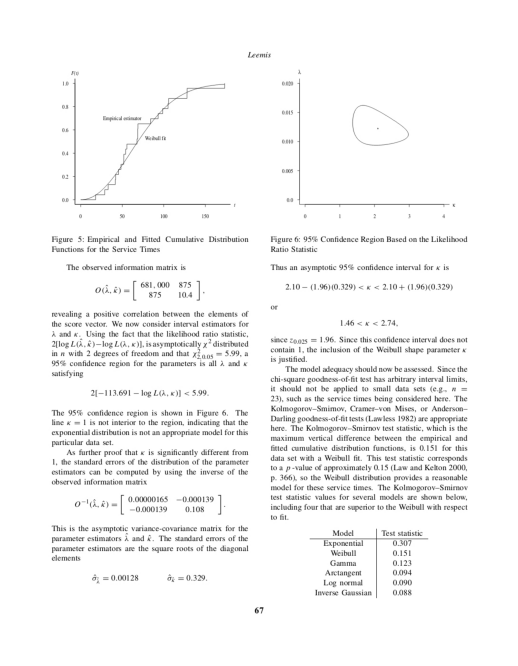

DETECTED TABLE BY DENSENET121
   column_0 column_1 column_2
0   Veibull     O15!        -
1    jerome     0.12        -
2  otargert     9.09        -
3         3    norma    9.09%
I M A G E


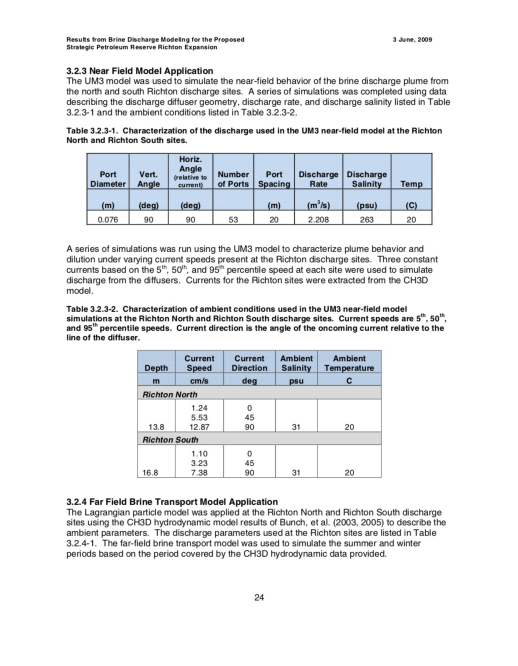

DETECTED TABLE BY VGG19
     column_0    column_1       column_2  column_3  column_4 column_5  \
0          0)        sama           ANCE     SHAUN    BINED,        -   
1           -           -              -         -         -        -   
2           -           -              -         -         -        -   
3           -           -              -         -         -        -   
4           -           -              -         -         -        -   
5           -           -              -         -         -        -   
6      Horiz.           -              -         -         -        -   
7        Port           |          vert.         |      quer        |   
8   Diameter|       Angle              |  �curent)         |       of   
9         (m)       (deg)          (deg)      (m),    (m*/s)    (psu)   
10      9.976          30             30        53        20    2.298   
11          -           -              -         -         -        -   
12          -           -  

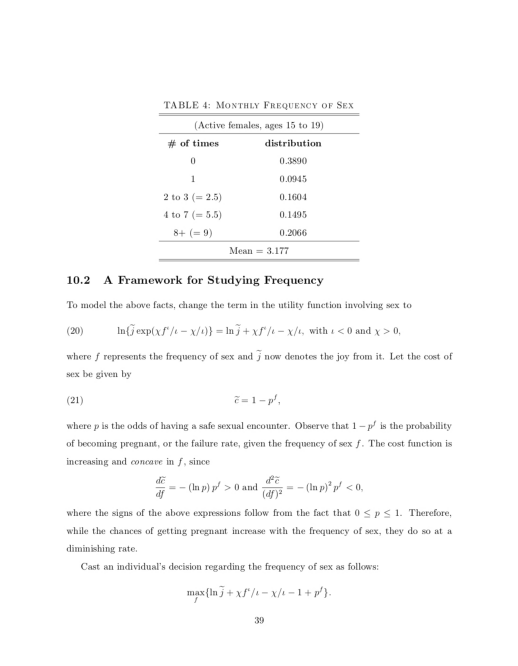

DETECTED TABLE BY XCEPTION
   column_0  column_1 column_2      column_3 column_4 column_5
0      .BLE        4:  MONTHLY     FREQUENCY       OF       SE
1         -         -        -             -        -        -
2         -         -        -             -        -        -
3   (Active  females,     ages            15       to      19)
4         -         -        -             -        -        -
5         #        of    times  distribution        -        -
6         8    8.3898        -             -        -        -
7         1    9.0845        -             -        -        -
8         2        to        3            (=     2.5)   9.1684
9         4        to        7        (=5.5)   9.1485        -
10       8+        (=       8)        0.2066        -        -
I M A G E


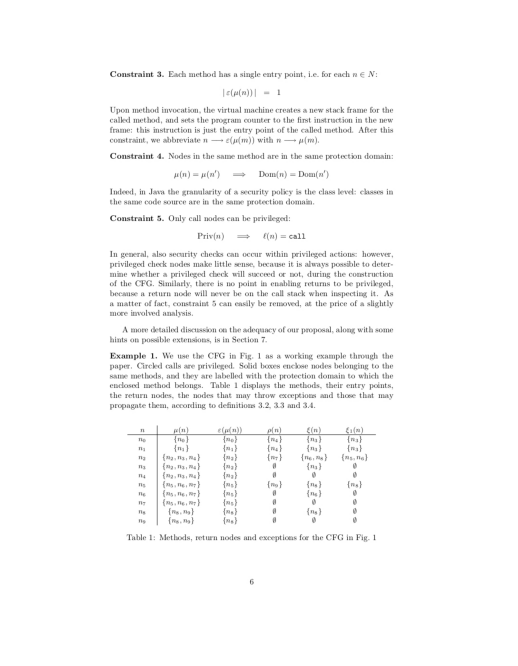

DETECTED TABLE BY VGG19
      column_0 column_1
0           ae        -
1         {no}        -
2          {m}        -
3   {no,n3,na}        -
4   {no,n3,n3}        -
5   {no,n3,n3}        -
6   {ns,no,n7}        -
7           u}        -
8           (4        -
9         ino}        -
10         ie)        -
11        {na}        -
12        {na}        -
13        {na}        -
14        {ns}        -
15        {ns}        -
16        {ns}        -
17        {ns}        -
18        {ns}        -
19           :        -
20           )        -
21          tn        }
22          tw        -
23        {no}        -
24        ecss        -
I M A G E


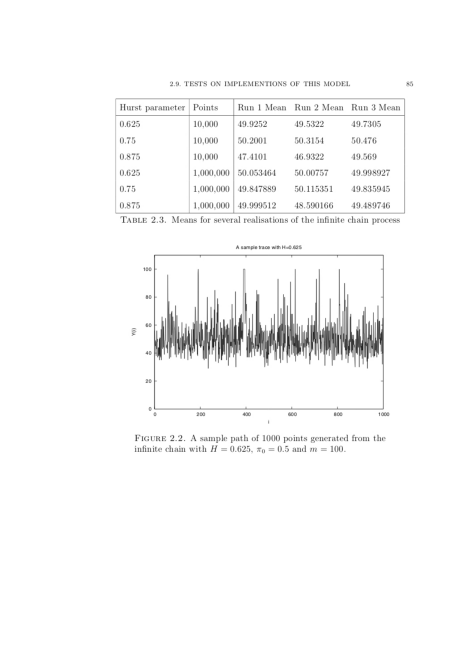

DETECTED TABLE BY XCEPTION
     column_0      column_1 column_2 column_3 column_4 column_5 column_6  \
0      VTIONS            OF     THIS     MODE        -        -        -   
1           -             -        -        -        -        -        -   
2         Run             1     Mean      Run        2     Mean      Run   
3           -             -        -        -        -        -        -   
4         :st     parameter        |   Points        -        -        -   
5      9.625,       19,090.        -        -        -        -        -   
6        9.75        19,990        -        -        -        -        -   
7      9.875,        19,090        -        -        -        -        -   
8      9.625,     1,999,090        -        -        -        -        -   
9           5     1,999,090        -        -        -        -        -   
10         75     1,999,090        -        -        -        -        -   
11          -             -        -        -        -       

In [33]:
images = os.listdir(os.path.join('data', 'ICDAR 2017', 'table_images'))[:20]
result_paths = ['densenet121', 'efficientnetb0','resnet50', 'vgg19', 'xception']


for each_image in images[:5]:
    img_fname = os.path.join('data', 'ICDAR 2017', 'table_images', each_image)
    img = Image.open(img_fname)
    plt.figure(figsize=(10,12))
    print("I M A G E")
    print("="*15)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    r = np.random.randint(len(result_paths))
    any_model = result_paths[r]
    print("DETECTED TABLE BY {}".format(any_model.upper()))
    print("="*15)
    csv_fname = os.path.join('output', any_model, each_image.replace('png', 'csv'))
    try:
        df = pd.read_csv(csv_fname)
    except:
        print("CSV is empty")
    print(df)
       

## Tensorboard Plots

1. Epoch_vs_Loss
![Epoch_vs_Loss](https://i.ibb.co/mcr02rM/loss.png)


2. Epoch_vs_Table_Accuracy
![Epoch_vs_Table_Accuracy](https://i.ibb.co/x8chhB2/table-acc.png)


3. Epoch_vs_Column_Accuracy
![Epoch_vs_Column_Accuracy](https://i.ibb.co/gDpW6JM/column-acc.png)

**INDEX**

![index](https://i.ibb.co/DpdKrCc/index.png)